# Distributed representations


1. Sparse features  
    1.1 Hashing trick  
    1.2 Categorial features  
    
    Note about semi-supervised learning.
    
2. Word2vec  
    2.1 skip-gram model  
    2.2 continious bag of words model  
    2.3 Co-occurence matrix  
    2.4 Glove    
    

## 1 Sparse features
### 1.1 Hashing trick

Basically it is a substution (string_token) -> hash(string_token) of fixed size  
    
Hello, polynomial hash for strings and MurmurHash3 (used in sklearn)  

Pros:
    1. extrapolate on unseen words, scalable
    2. reduce feature dimension
Cons:
    1. no inverse transform possible
    2. collisions

In [1]:
# demonstrate on US airlines twitter dataset for sentiment analysis
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


SEED = 1337


df = pd.read_csv('../seminar_10/Tweets.csv')

y = LabelEncoder().fit_transform(df.airline_sentiment)

df_train, df_test, y_train, y_test = model_selection.train_test_split(df, y, test_size=0.25, 
                                                                      stratify=y, # WHY
                                                                      random_state=SEED, 
                                                                      shuffle=True) # WHY

# model v1
# Simple BOW model, binary matrix  
# Let's try to reduce number of features with hashing
model1 = Pipeline([
    ('text_vect', HashingVectorizer(analyzer='word', n_features=500, ngram_range=(1,1), norm=None, binary=True)),
    ('logreg', LogisticRegressionCV(Cs=10, cv=3, scoring='neg_log_loss', n_jobs=-1, 
                                    multi_class='multinomial', random_state=SEED))
])

model1.fit(df_train.text, y_train)
print('train logloss', metrics.log_loss(y_train, model1.predict_proba(df_train.text)))
print('test logloss', metrics.log_loss(y_test, model1.predict_proba(df_test.text)))

train logloss 0.559925312648
test logloss 0.629119988516


### 1.2 Categorial features in linear models

In [2]:
# add categorial feature to our linear model with one-hot encoding

# categorial features
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [3]:
from sklearn.preprocessing import OneHotEncoder

text_vec = HashingVectorizer(analyzer='word', n_features=500, ngram_range=(1,1), norm=None, 
                             binary=True)
X1_train = text_vec.fit_transform(df_train.text).toarray()

tmp_le = LabelEncoder()
X2_train = tmp_le.fit_transform(df_train.airline.values).reshape(-1,1)

enc = OneHotEncoder(sparse=False)
X2_train = enc.fit_transform(X2_train)
print('one-hot enc shape', X2_train.shape)

X_train = np.hstack([X1_train, X2_train])

model2 = LogisticRegressionCV(Cs=10, cv=3, scoring='neg_log_loss', n_jobs=-1, 
                                    multi_class='multinomial', random_state=SEED)
model2.fit(X_train, y_train)

X1_test = text_vec.transform(df_test.text).toarray()
X2_test = tmp_le.transform(df_test.airline.values).reshape(-1,1)
X2_test = enc.transform(X2_test)
X_test = np.hstack([X1_test, X2_test])

print('train logloss', metrics.log_loss(y_train, model2.predict_proba(X_train)))
print('test logloss', metrics.log_loss(y_test, model2.predict_proba(X_test)))

one-hot enc shape (10980, 6)
train logloss 0.558588706479
test logloss 0.627312575957


## 2 Word2vec
![image](http://nlpx.net/wp/wp-content/uploads/2015/11/word2vec.png)
### 2.1 Skip-gram model
![image](https://i.stack.imgur.com/igSuE.png)

For each word t predict surrounding words in a window of size m

Objective is maximize probability of context words given the current center word:  
    
$J(\theta) = \prod^T_{t=1} \prod_{-m \le j \le m; j != 0 }  p(w_{t+j} | w_t; \theta)  \rightarrow max $

or negative log-likelihood:

$J(\theta) = -\frac{1}{T}\sum^T_{t=1} \sum_{-m \le j \le m; j != 0 }  log p(w_{t+j} | w_t; \theta)  \rightarrow max $

$p(w_{t+j} | w_t) = p(out | center) = \frac{exp(u_{out}^T v_{center})}{\sum_k=1^K exp(u_{k}^T v_{center})}$

Using negative sampling with k samples:   
    
$log p(w_{t+j} | w_t; \theta) = log \sigma(u_{outer}^T v_{center})  + \sum_{i=1}^k E_{j ~ P(w)} [log \sigma (-u_j^T v_{center})]$

In [4]:
df = pd.read_csv('ner_dataset.csv', encoding='latin-1')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
df = df.loc[:10000]

In [6]:
df.Tag.value_counts(normalize=True)

O        0.848215
B-gpe    0.030297
B-geo    0.024498
I-per    0.020598
B-org    0.017598
B-per    0.015998
B-tim    0.014899
I-org    0.013999
I-geo    0.003100
B-art    0.002800
I-gpe    0.002000
I-art    0.002000
I-tim    0.001300
B-eve    0.001000
I-eve    0.001000
B-nat    0.000500
I-nat    0.000200
Name: Tag, dtype: float64

In [12]:
%%time
from tqdm import tqdm

current = df.loc[0, 'Sentence #']
for j in tqdm(range(df.shape[0])):
    if pd.isnull(df.loc[j, 'Sentence #']):
        df.loc[j, 'Sentence #'] = current
    else:
        current = df.loc[j, 'Sentence #']

100%|██████████| 10001/10001 [00:11<00:00, 891.79it/s]

CPU times: user 11.3 s, sys: 88 ms, total: 11.3 s
Wall time: 11.3 s


In [13]:
df.shape

(10001, 4)

In [14]:
sentences_list = list(df.groupby('Sentence #').Word.agg(lambda col: list(col)).values)

In [15]:
%%time

from gensim.models.word2vec import Word2Vec


w2v = Word2Vec(sentences_list, negative=5, size=100, iter=100,
               sg=1)

CPU times: user 1.83 s, sys: 4 ms, total: 1.84 s
Wall time: 648 ms


In [16]:
w2v.wv.most_similar('police')

[('arrested', 0.7161649465560913),
 ('news', 0.5250526666641235),
 ('Bali', 0.49507197737693787),
 ('authorities', 0.48440536856651306),
 ('1995', 0.4536770284175873),
 ('Ramda', 0.44481196999549866),
 ('Indonesian', 0.429607629776001),
 ('men', 0.419624388217926),
 ('Muslim', 0.41935527324676514),
 ('religious', 0.41110479831695557)]

### 2.2 CBOW model

![!image](http://chaoyangzhu.com/2017/08/19/Word2Vec-the-Skip-Gram-and-Continuous-Bag-of-Words-Model/CBOW.png)

$h = W^T x$  
$x = [w_{j-m}, w_{j-m+1}, ... w_{j-1}, w_{j+1}, ..., w_{j+m}]$  

$p(w_j | x) = \frac{exp(v_j^T h)}{\sum_k=1^K exp(v_k^T h)}$

In [17]:
%%time

from gensim.models.word2vec import Word2Vec


w2v = Word2Vec(sentences_list, negative=5, size=100, iter=100,
               sg=0)

CPU times: user 780 ms, sys: 4 ms, total: 784 ms
Wall time: 286 ms


In [18]:
w2v.wv.most_similar('police')

[('arrested', 0.9197296500205994),
 ('they', 0.8160843849182129),
 ('one', 0.8109095096588135),
 ('They', 0.8108460903167725),
 ('men', 0.7938530445098877),
 ('Officials', 0.7803452014923096),
 ('news', 0.7786381244659424),
 ('Bali', 0.7746149897575378),
 ('Ramda', 0.773020327091217),
 ('reported', 0.7419112920761108)]

### 2.3 Co-occurence matrix

$P_{ij}$ - occurance of ith word along with j in the window of size m

Cons: 
1. Very high-dimensional, not used in practice
2. Hard to add new words and docs

Solution for 1:
1. Use some dimension-reduction method, usually SVD

Singular Value Decomposition

$M = U \Sigma V$  
$Mv = \sigma u$  
$M^{*}u = \sigma v$   
U, V are unitary matrices  
$\Sigma$ - diagonal


$O(nm^2)$ for case n < m

### 2.4 Glove

$J(\theta) = \frac{1}{2} \sum_{i,j=1}^W f(P_{ij})(u_i^T v_j - log P_{ij})$

pip install glove-python

In [19]:
from glove import Corpus, Glove


# construct co-occurance matrix
corpus = Corpus()
corpus.fit(sentences_list, window=5)


glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=100, no_threads=4, verbose=False)
glove.add_dictionary(corpus.dictionary)

In [20]:
glove.most_similar('police')

[('have', 0.96584710117145967),
 ('been', 0.94980699423519754),
 ('now', 0.91982068464752376),
 ('arrested', 0.89106702413428185)]

In [21]:
glove.word_vectors[glove.dictionary['police']]

array([-0.06373107,  0.00660779,  0.00198552,  0.01588677, -0.04370594,
        0.01726277,  0.03111042, -0.03803431,  0.01086599, -0.00552099,
       -0.0255159 ,  0.02388672, -0.02132961,  0.04047212, -0.0048955 ,
        0.00786338,  0.00681678,  0.02083918,  0.06618839, -0.00561955,
        0.01100433, -0.02659185, -0.02236061, -0.01816501, -0.02355093,
       -0.00503574, -0.0024676 , -0.02036608, -0.03039759,  0.01722127,
        0.0005871 , -0.00363654,  0.01328764,  0.00019342,  0.03065761,
       -0.00217669,  0.01583674, -0.03217559, -0.03417455,  0.0162312 ,
       -0.04813819, -0.01857898,  0.04468576, -0.00634232,  0.00877675,
        0.0330481 , -0.02542432,  0.02333535,  0.01009918, -0.03192986,
        0.01421471, -0.01503508, -0.00372783,  0.01537362,  0.05988799,
        0.04015709,  0.00135291,  0.00476957, -0.01157399, -0.02555511,
        0.00330979,  0.04183831, -0.00037858, -0.01671695, -0.00691607,
       -0.02183392,  0.01438478,  0.00939871, -0.02542321, -0.00

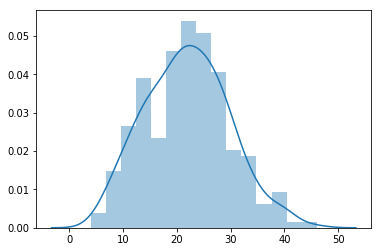

In [22]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns


sns.distplot([len(x) for x in sentences_list])

In [23]:
f_words = []
f_pos = []
y = []

window = 3
for t in tqdm(range(df.shape[0])):
    start_sentence = df[df['Sentence #'] == df.loc[t, 'Sentence #']].index.min()
    end_sentence = df[df['Sentence #'] == df.loc[t, 'Sentence #']].index.max()
    
    r_pos = []
    r_words = []
    
    for i in range(t-window, t):
        if i < start_sentence:
            r_words.append(None)
            r_pos.append(None)
        else:
            r_words.append(df.loc[i, 'Word'])
            r_pos.append(df.loc[i, 'POS'])
            
            
    for i in range(t+1, t+window+1):
        if i > end_sentence:
            r_words.append(None)
            r_pos.append(None)
        else:
            r_words.append(df.loc[i, 'Word'])
            r_pos.append(df.loc[i, 'POS'])
            
    f_words.append(r_words)
    f_pos.append(r_pos)
    
    y.append(df.loc[t, 'Tag'])
    
    

100%|██████████| 10001/10001 [00:34<00:00, 290.43it/s]
